# Deep Learning Model
Neste notebook tem os seguintes modelos de aprendizado de profundo comparados:
- LSTM

## Importações

In [125]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import mean_squared_error

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf

# Other
from IPython.display import Image
import warnings
import pprint
import datetime
import os
import datetime

## Preparação do Diretório Principal

In [126]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname (os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}' 

In [127]:
prepare_directory_work(end_directory='notebooks')

'Current working directory: /home/campos/projects/tcc'

## Formatação das Células

In [128]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Guarantees visualization inside the jupyter
%matplotlib inline

# Print xxxx rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# pretty print
pp = pprint.PrettyPrinter(indent=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
plt.style.use('seaborn')  # fivethirtyeight
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=15)
plt.rc('legend',fontsize=15)

# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='dark', palette='deep')

plt.style.use('fivethirtyeight')

---

## Carregamento dos Dados

In [130]:
%%time

df_vale3 = pd.read_csv('data/cleansing/df_vale3_cleansing.csv',
                        encoding='utf8',
                        delimiter=',',
                        parse_dates=True,
                        index_col=0,
                        verbose=True)

Tokenization took: 1.77 ms
Type conversion took: 2.29 ms
Parser memory cleanup took: 0.00 ms
CPU times: user 10.5 ms, sys: 283 µs, total: 10.7 ms
Wall time: 11 ms


In [131]:
print(df_vale3.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2445 entries, 2010-07-12 to 2020-05-28
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   preco         2445 non-null   float64
 1   residuos      2445 non-null   float64
 2   tendencia     2445 non-null   float64
 3   sazonalidade  2445 non-null   float64
 4   diff_1        2445 non-null   float64
 5   diff_2        2445 non-null   float64
 6   diff_3        2445 non-null   float64
 7   diff_4        2445 non-null   float64
 8   diff_5        2445 non-null   float64
dtypes: float64(9)
memory usage: 191.0 KB
None


In [132]:
df_vale3.head()

,preco,residuos,tendencia,sazonalidade,diff_1,diff_2,diff_3,diff_4,diff_5
data,,,,,,,,,
2010-07-12,40.000000,1.002310,41.827333,1.000149,-0.600000,-0.460000,0.490000,0.980000,0.420000
2010-07-13,40.070000,1.036654,41.910833,0.998563,0.070000,-0.530000,-0.390000,0.560000,1.050000
2010-07-14,40.080000,1.028377,41.977833,1.000439,0.010000,0.080000,-0.520000,-0.380000,0.570000
2010-07-15,39.760000,1.044658,42.045833,1.000935,-0.320000,-0.310000,-0.240000,-0.840000,-0.700000
2010-07-16,38.880000,1.028132,42.123500,1.001784,-0.880000,-1.200000,-1.190000,-1.120000,-1.720000


---

## Divisão dos Dados

In [133]:
size_train = 2414
size_test = 31
print(size_train)
print(size_test)

df_train = df_vale3.iloc[:size_train]
df_test = df_vale3.iloc[size_train:]
print(df_train.columns)
print(df_test.columns)

2414
31
Index(['preco', 'residuos', 'tendencia', 'sazonalidade', 'diff_1', 'diff_2',
       'diff_3', 'diff_4', 'diff_5'],
      dtype='object')
Index(['preco', 'residuos', 'tendencia', 'sazonalidade', 'diff_1', 'diff_2',
       'diff_3', 'diff_4', 'diff_5'],
      dtype='object')


Text(0.5, 1.0, 'Train size: 2414')

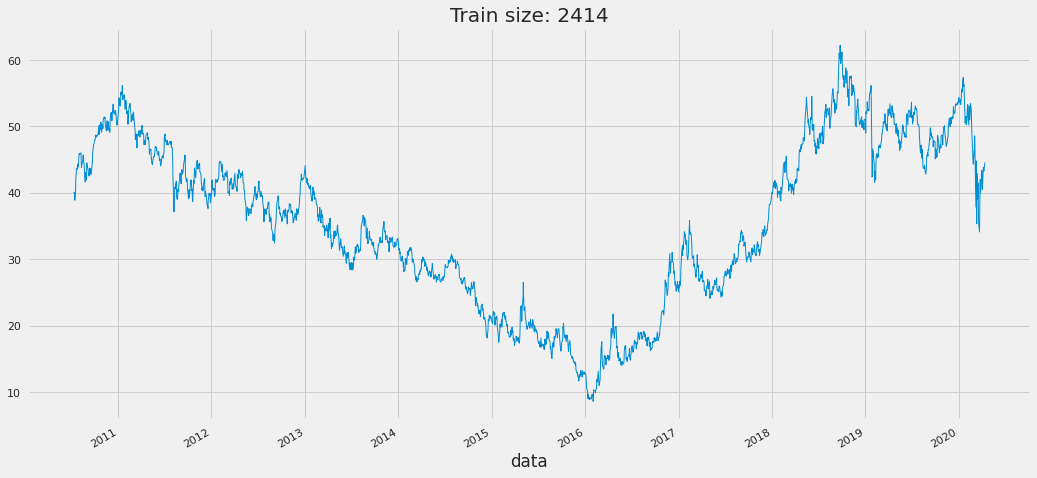

In [134]:
df_train['preco'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Train size: {len(df_train)}')

Text(0.5, 1.0, 'Test size: 31')

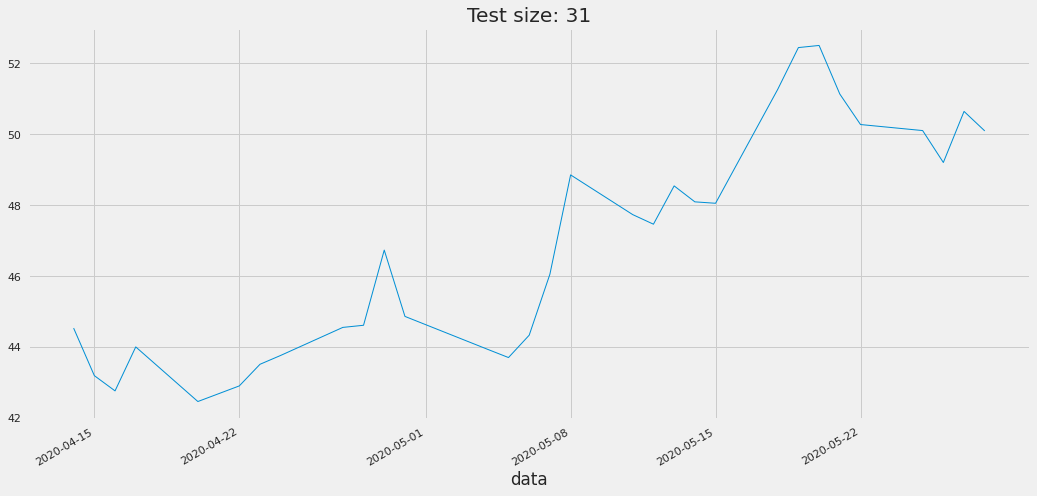

In [135]:
df_test['preco'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Test size: {len(df_test)}')

In [136]:
df_train.index

DatetimeIndex(['2010-07-12', '2010-07-13', '2010-07-14', '2010-07-15',
               '2010-07-16', '2010-07-19', '2010-07-20', '2010-07-21',
               '2010-07-22', '2010-07-23',
               ...
               '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02',
               '2020-04-03', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-13'],
              dtype='datetime64[ns]', name='data', length=2414, freq=None)

In [137]:
df_test.index

DatetimeIndex(['2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-20', '2020-04-22', '2020-04-23', '2020-04-24',
               '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
               '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
               '2020-05-08', '2020-05-11', '2020-05-12', '2020-05-13',
               '2020-05-14', '2020-05-15', '2020-05-18', '2020-05-19',
               '2020-05-20', '2020-05-21', '2020-05-22', '2020-05-25',
               '2020-05-26', '2020-05-27', '2020-05-28'],
              dtype='datetime64[ns]', name='data', freq=None)

In [138]:

# X_train = X_train[::-1]
# y_train = y_train[::-1]

# X_test = X_test[::-1]
# y_test = y_test[::-1]

---

## Métrica de Avaliação

In [139]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

---

## Dicionário de Resultados

In [140]:
dict_results = {}

---

## Impressão dos Resutados

In [141]:
def show_result_model(df_train, df_test, y_forecast, model_name):
    future_forecast = pd.DataFrame(y_forecast,
                                   index=df_test.index,
                                   columns=['previsao'])
    mape = mean_absolute_percentage_error(df_test, y_forecast)
    mse = mean_squared_error(df_test, y_forecast, squared=True)
    dict_results[model_name] = [mape, mse]
    
    pd.concat([df_train, df_test, future_forecast], axis=1).plot()

    plt.legend()
    plt.grid(True)
    plt.xlabel("Tempo (dias)", fontsize=20)
    plt.ylabel("Preço (R$)", fontsize=20)
    plt.title(f'MAPE = {mape:.2f} % | MSE = {mse:.2f}', fontsize=25)

---

## Normalização dos Dados

In [142]:
train_max = df_train.max()
train_min = df_train.min()

train = (df_train - train_min)/(train_max - train_min)
test = (df_test - train_min)/(train_max - train_min)

In [143]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    
    return np.array(Xs).astype('float32'), np.array(ys).astype('float32')

In [144]:
time_steps = 1

X_train, y_train = create_dataset(train, train['preco'], time_steps)
X_test, y_test = create_dataset(test, test['preco'], time_steps)

---

## LSTM

In [145]:
# sequential model
model_lstm = Sequential(name='lstm_vale3')
model_lstm

#### Input Layer

In [146]:
#Adding the first LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))

#### Hidden Layers

In [147]:
# Adding a second LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))

#### Output Layer

In [148]:
model_lstm.add(Dense(units=1))

### Compilação da RNA

In [149]:
model_lstm.compile(loss='mean_squared_error',
                   optimizer='adam',
                   metrics=['accuracy'])

### Resumo da RNA

In [150]:
model_lstm.summary()

Model: "lstm_vale3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1, 50)             12000     
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 1, 50)             20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 50)             20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                2

---

## Treinamento
- batch_size: cria lote de treinamento de 30 em 30 dias

In [151]:
%%time


history = model_lstm.fit(X_train,
               y_train,
               epochs=1000,
               batch_size=30,
               shuffle=False,
               validation_split=0.10,
               verbose=0)
history

CPU times: user 18min 39s, sys: 2min 33s, total: 21min 13s
Wall time: 8min 58s


In [152]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [153]:
best_epochs = history.history["loss"].index(min(history.history["loss"]))
best_epochs

727

In [154]:
min(history.history["loss"])

0.0008026042487472296

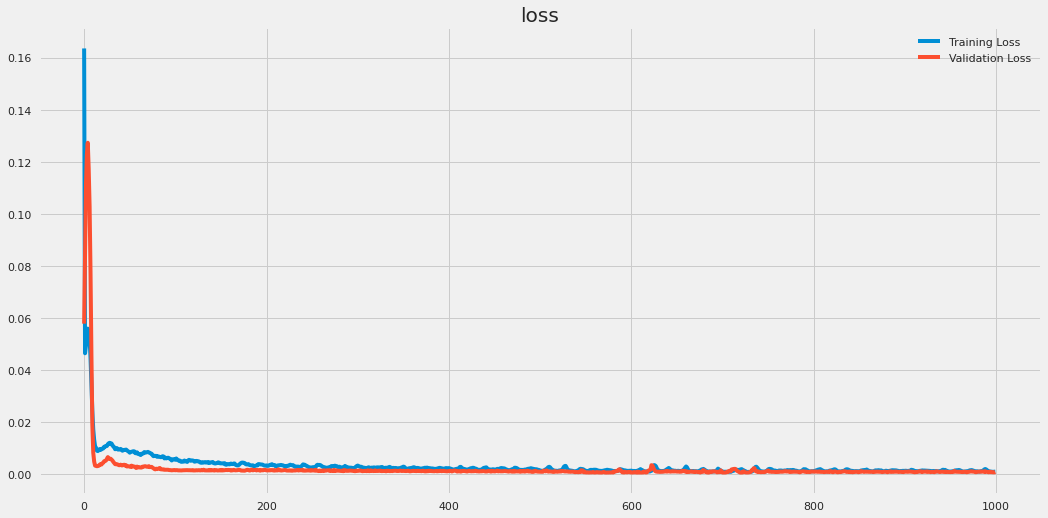

In [155]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title('loss')
plt.legend()
plt.show()

---

### Predict

In [156]:
y_pred = model_lstm.predict(X_test)

In [157]:
# Rescale the data back to the original scale
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]

In [158]:
y_test[:10]

array([43.189995, 42.760002, 44.      , 42.46    , 42.9     , 43.510002,
       43.760002, 44.550003, 44.61    , 46.729996], dtype=float32)

In [159]:
len(y_test)

30

In [160]:
y_train[:10]

array([40.07    , 40.079998, 39.760002, 38.879997, 39.969997, 42.229996,
       42.47    , 43.370003, 43.71    , 43.730003], dtype=float32)

In [161]:
mean_absolute_percentage_error(df_test['preco'][:30], y_pred)

7.760199706168364

In [162]:
mean_absolute_percentage_error(y_test, y_pred)

7.718035578727722

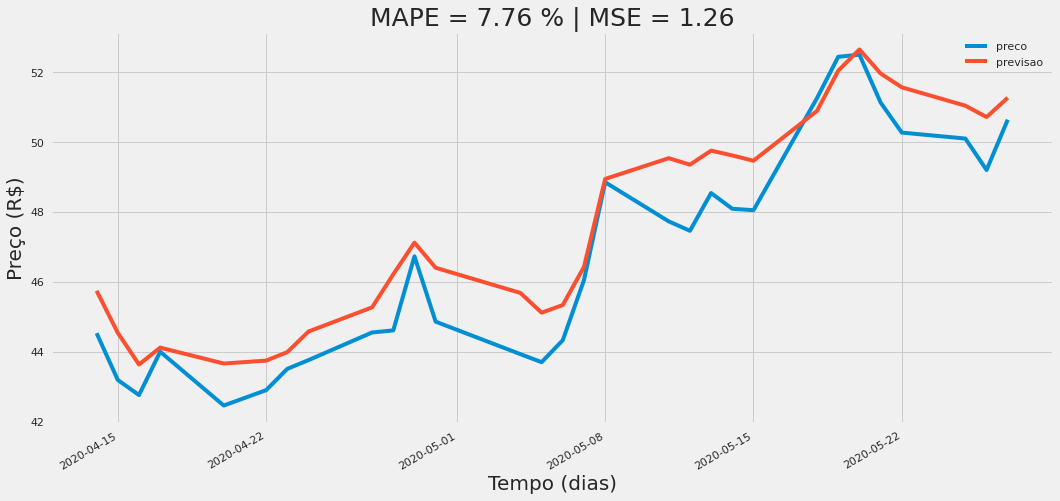

In [163]:
show_result_model(df_train=df_test['preco'][:30],
                  df_test=df_test['preco'][:30], 
                  y_forecast=y_pred,
                  model_name='model_lstm')

---

## Results

In [164]:
dict_results

{'model_lstm': [7.760199706168364, 1.2631785989134543]}

---